In [1]:
import pandas as pd
import numpy as np
from librosa.util import find_files
import librosa
import os
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from dataset import ASVspoof2019
from evaluate_tDCF_asvspoof19 import compute_eer_and_tdcf
from collections import defaultdict
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
def visualize_dev_and_eval(dev_feat, dev_labels, dev_tags, eval_feat, eval_labels, eval_tags, 
                           center, seed, out_fold):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
    # plt.ion()
    # c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
    #      '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    c = ['#ff0000', '#003366', '#ffff00']
    c_tag = ['#00ff00', '#00ffff', '#0000ff', '#ff00ff', '#990000', '#999900',
             '#009900', '#009999', '#00ff00', '#990000', '#999900', '#ff0000',
             '#003366', '#ffff00', '#f0000f', '#0f00f0', '#00ffff', '#0000ff', '#ff00ff']
    # plt.clf()
    torch.manual_seed(668)
    num_centers, enc_dim = center.shape
    ind_dev = torch.randperm(dev_feat.shape[0])[:5000].numpy()
    ind_eval = torch.randperm(eval_feat.shape[0])[:5000].numpy()

    dev_feat_sample = dev_feat[ind_dev]
    eval_feat_sample = eval_feat[ind_eval]
    dev_lab_sam = dev_labels[ind_dev]
    eval_lab_sam = eval_labels[ind_eval]
    dev_tag_sam = dev_tags[ind_dev]
    eval_tag_sam = eval_tags[ind_eval]
    if enc_dim > 2:
        X = np.concatenate((center, dev_feat_sample, eval_feat_sample), axis=0)
        os.environ['PYTHONHASHSEED'] = str(668)
        np.random.seed(668)
        X_tsne = TSNE(random_state=seed, perplexity=40, early_exaggeration=40).fit_transform(X)
        center = X_tsne[:num_centers]
        feat_dev = X_tsne[num_centers:num_centers+5000]
        feat_eval = X_tsne[num_centers + 5000:]
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        ex_ratio = pca.explained_variance_ratio_
        center_pca = X_pca[:num_centers]
        feat_pca_dev = X_pca[num_centers:num_centers+5000]
        feat_pca_eval = X_pca[num_centers + 5000:]
    else:
        center_pca = center
        feat_dev = dev_feat_sample
        feat_eval = eval_feat_sample
        feat_pca_dev = feat_dev
        feat_pca_eval = feat_eval
        ex_ratio = [0.5, 0.5]
    # t-SNE visualization
    ax1.plot(feat_dev[dev_lab_sam == 0, 0], feat_dev[dev_lab_sam == 0, 1], '.', c=c[0], markersize=1.2)
    ax1.plot(feat_dev[dev_lab_sam == 1, 0], feat_dev[dev_lab_sam == 1, 1], '.', c=c[1], markersize=1.2)
#     ax1.plot(feat_dev[dev_tag_sam == 17, 0], feat_dev[dev_tag_sam == 17, 1], '.', c='olive', markersize=1)
    ax1.axis('off')
    # ax1.plot(center[:, 0], center[:, 1], 'x', c=c[2], markersize=5)
    # ax2.plot(center[:, 0], center[:, 1], 'x', c=c[2], markersize=5)
    plt.setp((ax2), xlim=ax1.get_xlim(), ylim=ax1.get_ylim())
    ax2.plot(feat_eval[eval_lab_sam == 0, 0], feat_eval[eval_lab_sam == 0, 1], '.', c=c[0], markersize=1.2)
    ax2.plot(feat_eval[eval_lab_sam == 1, 0], feat_eval[eval_lab_sam == 1, 1], '.', c=c[1], markersize=1.2)
    ax2.plot(feat_eval[eval_tag_sam == 17, 0], feat_dev[eval_tag_sam == 17, 1], '.', c='darkgreen', markersize=1.5)
    ax2.axis('off')
    # ax1.legend(['genuine', 'spoofing', 'center'])
    # PCA visualization
    ax3.plot(feat_pca_dev[dev_lab_sam == 0, 0], feat_pca_dev[dev_lab_sam == 0, 1], '.', c=c[0], markersize=1.2)
    ax3.plot(feat_pca_dev[dev_lab_sam == 1, 0], feat_pca_dev[dev_lab_sam == 1, 1], '.', c=c[1], markersize=1.2)
    # ax3.plot(center_pca[:, 0], center_pca[:, 1], 'x', c=c[2], markersize=5)
    ax3.axis('off')
    plt.setp((ax4), xlim=ax3.get_xlim(), ylim=ax3.get_ylim())
    ax4.plot(feat_pca_eval[eval_lab_sam == 0, 0], feat_pca_eval[eval_lab_sam == 0, 1], '.', c=c[0], markersize=1.2)
    ax4.plot(feat_pca_eval[eval_lab_sam == 1, 0], feat_pca_eval[eval_lab_sam == 1, 1], '.', c=c[1], markersize=1.2)
    ax4.plot(feat_pca_eval[eval_tag_sam == 17, 0], feat_pca_dev[eval_tag_sam == 17, 1], '.', c='darkgreen', markersize=1.5)
    ax4.axis('off')
    # ax4.legend(['genuine', 'spoofing', 'center'])
    plt.savefig(os.path.join(out_fold, '_vis_feat.jpg'))
    plt.show()
    fig.clf()
    plt.close(fig)

def get_features(feat_model_path, part):
    model = torch.load(feat_model_path)
    dataset = ASVspoof2019("LA", "/data2/neil/ASVspoof2019LA/", part,
                            "LFCC", feat_len=750, pad_chop=True, padding="repeat")
    dataLoader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0,
                                collate_fn=dataset.collate_fn)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    ip1_loader, tag_loader, idx_loader, score_loader = [], [], [], []
    for i, (cqcc, audio_fn, tags, labels, channel) in enumerate(tqdm(dataLoader)):
        cqcc = cqcc.transpose(2,3).float().to(device)
        tags = tags.to(device)
        labels = labels.to(device)
        feats, _ = model(cqcc)
        ip1_loader.append(feats.detach().cpu().numpy())
        idx_loader.append((labels.detach().cpu().numpy()))
        tag_loader.append((tags.detach().cpu().numpy()))
    features = np.concatenate(ip1_loader, 0)
    labels = np.concatenate(idx_loader, 0)
    tags = np.concatenate(tag_loader, 0)
    gen_feats = features[labels==0]
    return features, labels, tags


In [3]:
feat_model_path = "/data/neil/antiRes/models1028/ocsoftmax/anti-spoofing_lfcc_model.pt"
loss_model_path = "/data/neil/antiRes/models1028/ocsoftmax/anti-spoofing_loss_model.pt"
center = torch.load(loss_model_path).center.detach().cpu().numpy()
dev_feat, dev_labels, dev_tags = get_features(feat_model_path, "dev")
eval_feat, eval_labels, eval_tags = get_features(feat_model_path, "eval")
# visualize_dev_and_eval(dev_feat, dev_labels, dev_tags, eval_feat, eval_labels, eval_tags, center, 78, "/data/neil/antiRes/models1028/ocsoftmax")


/home/neil/anaconda3/envs/analyse/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
100%|██████████| 4453/4453 [03:40<00:00, 20.16it/s]


In [4]:
import pickle

with open('visualization.pkl', 'wb') as handle:
    pickle.dump([dev_feat, dev_labels, dev_tags, eval_feat, eval_labels, eval_tags, center], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('visualization.pkl', 'rb') as handle:
#     dev_feat, dev_labels, dev_tags, eval_feat, eval_labels, eval_tags, center = pickle.load(handle)

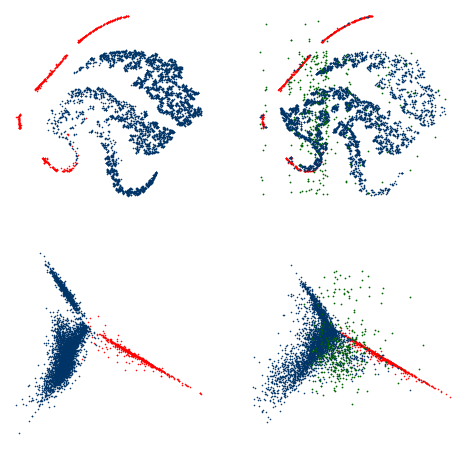

In [5]:
visualize_dev_and_eval(dev_feat, dev_labels, dev_tags, eval_feat, eval_labels, 
                       eval_tags, center, 78, "/data/neil/antiRes/models1028/ocsoftmax")